# Deskewing
In this notebook we benchmark deskweing using [QI2lab/OPM](https://github.com/QI2lab/OPM), [DEXP](https://github.com/royerlab/dexp) and py-clesperanto.

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import timeit
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

cle.select_device("rtx")

<Quadro RTX 6000 on Platform: NVIDIA CUDA (1 refs)>

You will need to install [cupy](https://docs.cupy.dev/en/stable/install.html) for the following

In [2]:
import cupy
device = cupy.cuda.Device(0)
device.compute_capability, device.mem_info

('75', (22707625984, 24159191040))

In [3]:
from dexp.processing.deskew import yang_deskew, classic_deskew

In [4]:
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread('../data/RBC_1_timepoint.tif')
original_image.shape

(501, 140, 1488)

In [5]:
# Source: https://github.com/QI2lab/OPM/blob/master/reconstruction/image_post_processing.py
# Licensed GPL 3 https://github.com/QI2lab/OPM/blob/master/LICENSE

import sys
import numpy as np
from pathlib import Path
from tifffile import tifffile
from numba import njit, prange
from functools import partial
import gc
import cupy as cp

    
# http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
@njit(parallel=True)
def deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    return output

In [6]:
def opm_deskew():
    return deskew(original_image,deskewing_angle_in_degrees,voxel_size_z_in_microns,voxel_size_x_in_microns)
    
deskewed = opm_deskew()
deskewed.shape

(70, 1158, 1488)

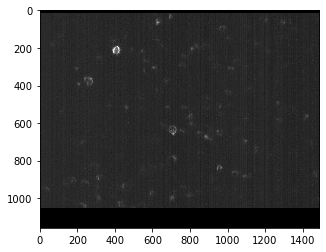

In [7]:
cle.imshow(deskewed[10])

In [8]:
def cle_deskew():
     return cle.deskew_y(original_image, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

deskewed = cle_deskew()
deskewed.shape

(70, 1158, 1488)

In [9]:
def dexp_deskew():
    return yang_deskew.yang_deskew(original_image,
               depth_axis=0,
               lateral_axis=1,
               dz=voxel_size_z_in_microns,
               dx=voxel_size_x_in_microns,
               angle=deskewing_angle_in_degrees,
               flip_depth_axis=False)

result = dexp_deskew()
result.shape

(69, 1488, 989)

In [10]:
def dexp_deskew_classic():
    return classic_deskew.classic_deskew(original_image,
               depth_axis=0,
               lateral_axis=1,
               dz=voxel_size_z_in_microns,
               dx=voxel_size_x_in_microns,
               angle=deskewing_angle_in_degrees,
               flip_depth_axis=False)

result = dexp_deskew_classic()
result.shape

(535, 140, 1488)

In [11]:
%timeit opm_deskew()

132 ms ± 5.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit cle_deskew()

298 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit dexp_deskew()

13.8 s ± 487 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit dexp_deskew_classic()

9.28 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
